# Model prediction (evoked)

purpose: predict whether a unit's accuracy will be below detection threshold ("dark unit") with fractional logistic regression

Model approach: 
* Data was binomial rather than binary, so that y was the number of successes out of N trials, then you could compute the proportion of successes and fit a binomial GLM.
* cross-validated training
* cross-validated backward feature model selection


takes 45 min to run

We used:

- link unit true features to accuracy (not directly available to ephysist):
    - unit's true distance to nearest site (to fix)
    - distance [OK]
    - firing_rate  [OK] 
    - signal to noise ratio [OK]  
    - synapse_class [OK]  
    - layers [OK]
    - etypes [OK]  
    - spike spatial extent [OK]
    - unit's soma size [TODO]
    - spike WaveMap shape profile [TODO]

- features available (or that can be approximated) to ephysists, sorted units':    
    - layers [OK]
    - etypes [OK]
    - distance [OK]
    - spike spatial extent [TODO]
    - firing_rate [TODO]
    - synapse_class [TODO]
    - signal-to-noise ratio [TODO]
    - spike WaveMap shape profile [TODO]
    - cell type based on spike temporal duration [TODO]

* Do not add:
    * inh_mini_frequency (only 1 value)
    * morphology (1284 values): not enough instance repeats for robust modeling

### Prerequisites

* have extracted ground truth waveforms: done [30.01.2024]

### Setup

activate npx

In [1]:
%load_ext autoreload
%autoreload 2
import os
import spikeinterface as si
import statsmodels.api as sm
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
import statsmodels.api as sm
from itertools import combinations, product
from statsmodels.tools.validation import float_like
import warnings
import random
import itertools
import copy
import seaborn as sns
import pickle

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 

PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.metrics.spike import get_spatial_spread_all_units, get_true_units_SNRs, get_true_unit_true_distance_to_nearest_site

# SETUP PATHS
data_conf, _ = get_config("silico_neuropixels", "stimulus").values()
SORTING_PATH = data_conf["sorting"]["sorters"]["kilosort3"]["output"]
GT_SORTING_PATH = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
RECORDING_PATH = data_conf["probe_wiring"]["input"]
BLUECONFIG_PATH = data_conf["dataeng"]["blueconfig"]
STUDY_FOLDER = data_conf["postprocessing"]["waveform"]["ground_truth"]["study"]
REC_FOLDER = data_conf["preprocessing"]["output"]["trace_file_path"]

# SETUP WAVEFORMS
MS_BEFORE = 3
MS_AFTER = 3

# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
COLOR_STIM = (0.6, 0.75, 0.1)
BOX_ASPECT = 1                  # square fig
FIG_SIZE = (4,4)
N_MAJOR_TICKS = 6
N_MINOR_TICKS = 12
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 14
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.right'] = False
# plt.rcParams['axes.spines.left'] = False
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.major.width'] = 1
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True}
# print(plt.rcParams.keys())

2024-02-16 17:00:42,526 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-16 17:00:42,569 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Custom functions

In [2]:
def create_dataset(SortingTrue, recording_path: str):
    """create dataset with predictor features
    and target sorting accuracy

    Args:
        SortingTrue (SpikeInterface Sorting Extractor): Sorting extractor
        with units metadata as saved properties

    Returns:
        _type_: _description_
    """
    # - add firing rate
    dataset = pd.DataFrame()
    dataset["firing_rate"] = np.array(SortingTrue.get_property("firing_rates"))

    # - add synapse
    dataset["synapse_class"] = pd.get_dummies(
        SortingTrue.get_property("synapse_class")
    )["EXC"].values

    # - add etype
    etype_df = pd.get_dummies(SortingTrue.get_property("etype"))
    dataset = pd.merge(dataset, etype_df, left_index=True, right_index=True)

    # - record layer
    feature_layer_df = pd.get_dummies(SortingTrue.get_property("layer"))
    feature_layer_df.columns = [
        "layer_1",
        "layer_2",
        "layer_3",
        "layer_4",
        "layer_5",
        "layer_6",
    ]
    dataset = pd.merge(dataset, feature_layer_df, left_index=True, right_index=True)

    # - add distance to nearest site
    dataset["distance"] = get_true_unit_true_distance_to_nearest_site(
        SortingTrue, recording_path
    )

    # - add exc_mini_frequency (5 unique values)
    dataset["exc_mini_frequency"] = SortingTrue.get_property("exc_mini_frequency")

    # - add dynamics_holding_current
    dataset["dynamics_holding_current"] = SortingTrue.get_property(
        "dynamics_holding_current"
    )

    # - add dynamics_holding_current
    dataset["model_template"] = SortingTrue.get_property("model_template")

    # - add target: sorting accuracy
    dataset["sorting_accuracy"] = SortingTrue.get_property("sorting_accuracy")

    # - add unit ids as indices
    dataset.index = SortingTrue.unit_ids
    return dataset


def pairs(*lists):
    for t in combinations(lists, 2):
        for pair in product(*t):
            yield pair


def loglike(fit_output, params, scale: float, exog: np.ndarray, endog: np.array):
    """Calculate the log likelihood of observing the true sorting accuracies "endog"
    given the fitted glm model "fit_output"
    you can get by inspecting result_1.model.loglike
    code = inspect.getsource(result_1.model.loglike)
    print(code)

    Args:
        fit_output: fitted glm model
        exog: predictive features used to make predictions
        - independent variables
        endog: true sorting accuracy (dependent variable)

    Note:
        Setting the args as below should produce llf == fit_output.llf
        that is the log likelihood nproduced from fitting the training
        data
        - exog = fit_output.model.exog
        - endog = fit_output.model.endog
    """
    scale = float_like(scale, "scale", optional=True)
    var_weights = np.ones(exog.shape[0])
    freq_weights = np.ones(exog.shape[0])

    # make predictions
    # - same as calling result.model.predict(params, exog)
    linear_preds = np.dot(exog, params) + fit_output.model._offset_exposure
    expval = fit_output.model.family.link.inverse(linear_preds)
    if scale is None:
        scale = fit_output.model.estimate_scale(expval)

    # calculate loglikelihood of data
    llf = fit_output.model.family.loglike(
        endog,  # true sorting accuracy
        expval,  # predicted sorting accuracy
        var_weights,  # 1 by default
        freq_weights,  # 1 by default
        scale,
    )
    return llf


def get_single_fold_mcf_r2(
    model_formula: str, dataset: pd.DataFrame, split_ratio: float = 0.75, seed: int = 0
):
    """Calculate mcfadden pseudo r-squared for a single fold, sampling
    split_ratio instances of the dataset as train and 1-split_ratio as test

    Args:
        model_formula

    note:
        - mcfadden r2 formula: (1 - result_1.llf / result_1.llnull)
        - produced by statsmodel r2 = test_model.pseudo_rsquared(kind="mcf")

    Returns:
        mcfadden pseudo r-squared (float)
    """
    # GET MCF R2 FOR TEST MODEL

    random.seed(seed)

    # TRAIN -----------
    # calculate 75% of train
    n_train = np.round(split_ratio * dataset.shape[0]).astype(int)

    # sample n_train
    indices = np.arange(0, dataset.shape[0], 1).tolist()
    train_indices = random.sample(indices, n_train)
    train_dataset = dataset.iloc[train_indices, :]

    # train model on this fold
    model_1 = sm.GLM.from_formula(
        model_formula,
        family=sm.families.Binomial(),
        data=train_dataset,
    )
    result_1 = model_1.fit()

    # TEST -----------
    # create test dataset with remaining instances
    test_indices = list(set(indices) - set(train_indices))
    test_dataset = dataset.drop(
        columns=[
            "exc_mini_frequency",
            "dynamics_holding_current",
            "model_template",
        ]
    ).iloc[test_indices, :]

    # reorder test dataset features and add intercept
    # to make predictions and get loglikelihood
    features = result_1.params.index[1:]
    test_features = test_dataset.loc[:, features]
    test_features.insert(0, "intercept", 1)

    # test and eval
    llf = loglike(
        result_1,
        result_1.params,
        None,
        exog=test_features,
        endog=test_dataset["sorting_accuracy"],
    )

    # GET MCF R2 FOR NULL MODEL

    # train
    null_model = sm.GLM.from_formula(
        "sorting_accuracy ~ 1",
        family=sm.families.Binomial(),
        data=train_dataset,
    )
    null_model = null_model.fit()

    # test and eval
    ll_null = loglike(
        null_model,
        null_model.params,
        None,
        exog=np.array([test_features["intercept"]]).T,
        endog=test_dataset["sorting_accuracy"],
    )

    # fix r-squared in case ll_null==0
    if llf > 0 and ll_null == 0:
        return np.nan
    else:
        return 1 - llf / ll_null


def get_crossval_mcf_r2(
    dataset: pd.DataFrame,
    model_formula: str,
    split_ratio: float = 0.75,
    seeds: np.array = np.arange(0, 100, 1),
):
    """Calculate cross-validated mcfadden pseudo r-squared
    on test dataset

    Args:
        model_formula (str): glm model formula
        split_ratio (float, optional): _description_. Defaults to 0.75.
        seeds (np.array, optional): _description_. Defaults to np.arange(0, 100, 1).

    Returns:
        np.array: mcfadden pseudo r-squared
    """
    r2_all = []
    for seed in range(len(seeds)):
        try:
            r2 = get_single_fold_mcf_r2(
                model_formula, dataset, split_ratio=split_ratio, seed=seed
            )
        except:
            # can fail if SVD did not converge in Linear Least Squares
            # because of wrong covariance matrix
            r2 = np.nan
        r2_all.append(r2)
    return np.array(r2_all)


def get_combinations(lst):  # creating a user-defined method
    combination = []  # empty list
    for r in range(1, len(lst) + 1):
        # to generate combination
        combination.extend(itertools.combinations(lst, r))
    return combination


def count_combinations(features: list):
    all_combinations = get_combinations(features)  # method call
    return len(all_combinations)

### Check spike sample size

We need enough spikes per unit to get valid metrics.

In [3]:
# takes 6 secs
SortingTrue = si.load_extractor(GT_SORTING_PATH)

units with less than 1 spikes (ratio): 0.017973856209150325
units with less than 10 spikes (ratio): 0.07952069716775599
units with less than 30 spikes (ratio): 0.14106753812636166


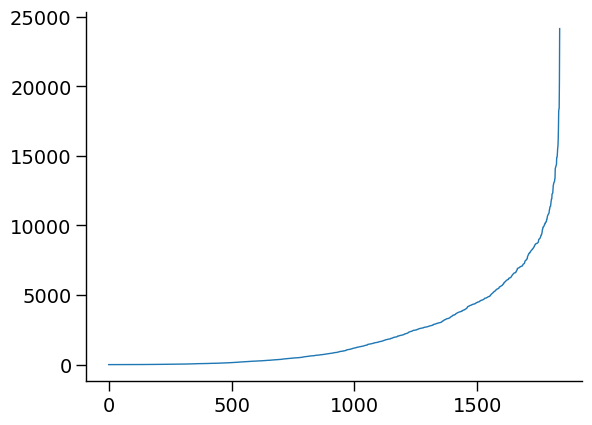

In [4]:
# calculate spike count per unit
nspikes = SortingTrue.get_total_num_spikes()
nunits = len(nspikes)
sorted_nspikes = np.sort(list(nspikes.values()))
plt.plot(sorted_nspikes)
print("units with less than 1 spikes (ratio):", sum(sorted_nspikes < 2) / nunits)
print("units with less than 10 spikes (ratio):", sum(sorted_nspikes < 10) / nunits)
print("units with less than 30 spikes (ratio):", sum(sorted_nspikes < 30) / nunits)

### Create dataset

In [5]:
# check properties (metadata exist)
if len(SortingTrue.get_property_keys()) == 0:
    print("Add metadata to Sorting extractor before - see postprocessing notebooks")

# create dataset
dataset = create_dataset(SortingTrue, REC_FOLDER)

### Add new features

#### SNR

In [6]:
# takes 10 mins

# preprequisites
# - have extracted ground truth waveforms
snrs = get_true_units_SNRs(REC_FOLDER, STUDY_FOLDER, MS_BEFORE, MS_AFTER)

# add SNR to dataset if unit ids match
try:
    assert all(list(snrs.keys()) == dataset.index)
    dataset["snr"] = list(snrs.values())
except:
    print("SNR and dataset features' unit ids must be aligned")

#### Spatial extent

In [7]:
# takes 5 mins
# - have extracted ground truth waveforms
spatial_extent = get_spatial_spread_all_units(
    REC_FOLDER, STUDY_FOLDER, MS_BEFORE, MS_AFTER
)

# add spatial extent to dataset if unit ids match
try:
    assert all(list(spatial_extent.keys()) == dataset.index)
    dataset["spatial_extent"] = list(spatial_extent.values())
except:
    print("spatial extent and dataset features' unit ids must be aligned")

In [8]:
# display
dataset

,firing_rate,synapse_class,bAC,bIR,bNAC,bSTUT,cACint,cADpyr,cIR,cNAC,...,layer_4,layer_5,layer_6,distance,exc_mini_frequency,dynamics_holding_current,model_template,sorting_accuracy,snr,spatial_extent
12165,0.035655,1,0,0,0,0,0,1,0,0,...,0,0,0,35.880408,0.013875,-0.015435,hoc:cADpyr_L2TPC,0.504762,2.697296,832.778644
15894,0.404367,1,0,0,0,0,0,1,0,0,...,0,0,0,37.130547,0.013875,-0.008798,hoc:cADpyr_L2TPC,0.023138,1.631029,1008.444557
16652,0.703428,1,0,0,0,0,0,1,0,0,...,0,0,0,48.102859,0.013875,-0.012208,hoc:cADpyr_L2TPC,0.006364,0.542222,564.432429
17923,0.166943,1,0,0,0,0,0,1,0,0,...,0,0,0,40.293894,0.013875,-0.016666,hoc:cADpyr_L2TPC,0.031412,2.311889,791.641920
18371,0.194583,1,0,0,0,0,0,1,0,0,...,0,0,0,35.766017,0.013875,-0.014507,hoc:cADpyr_L2TPC,0.028921,2.361067,647.741385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4223302,0.010779,0,0,0,0,0,1,0,0,0,...,0,1,0,35.011665,0.010108,-0.031677,hoc:cACint_L23MC,0.004975,2.380556,828.049900
4225319,0.002488,0,0,0,0,0,1,0,0,0,...,0,1,0,44.911650,0.010108,-0.049141,hoc:cACint_L23MC,0.000335,3.865621,193.225056
4228700,1.559702,0,0,0,0,0,1,0,0,0,...,0,1,0,31.096023,0.010108,-0.047438,hoc:cACint_L23MC,0.001641,1.058728,859.592281
4229218,0.078496,0,0,0,0,0,1,0,0,0,...,0,1,0,45.918635,0.010108,-0.031170,hoc:cACint_L23MC,0.002421,0.453162,351.144368


### Model selection based on Goodness of fit (BIC stats)

* This analysis validates that training was successful (above chance, the null model).
* Nonlinear regression model. It does not reduce residual but uses Maximum Likelihood Estimation (MLE).
* Models with lower BICs best fit the data

note: regularization (model_1.fit_regularized()) is not implemented for that family

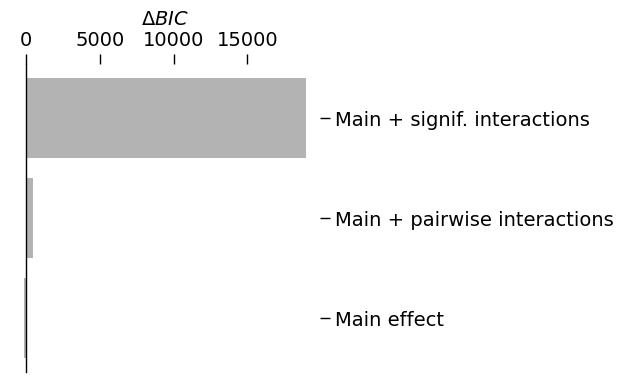

In [9]:
# takes 2 secs

# NULL MODEL
# ----------
null_model = sm.GLM.from_formula(
    "sorting_accuracy ~ 1",
    family=sm.families.Binomial(),
    data=dataset,
)
null_model = null_model.fit()

# MODEL 1 (no interactions)
# ------------------------
# note: regularization (model_1.fit_regularized()) is not implemented for that family
model_1 = sm.GLM.from_formula(
    """sorting_accuracy ~ 1 
    + layer_1 + layer_2 + layer_3 + layer_4 + layer_5 + layer_6 
    + bAC + bNAC + bSTUT + cACint + cADpyr + cNAC + cSTUT + dNAC + dSTUT
    + firing_rate
    + distance
    + synapse_class
    + snr      
    + spatial_extent
    """,
    family=sm.families.Binomial(),
    data=dataset,
)
result_1 = model_1.fit()

# MODEL 2 (all pairwise interactions)
# ----------------------------------
layers = ["layer_1", "layer_2", "layer_3", "layer_4", "layer_5", "layer_6"]
etypes = ["bAC", "bNAC", "bSTUT", "cACint", "cADpyr", "cNAC", "cSTUT", "dNAC", "dSTUT"]

# create all pairwise interactions
layers_x_etypes = ""
for pair in pairs(
    layers,
    etypes,
    ["firing_rate"],
    ["distance"],
    ["synapse_class"],
    ["snr"],
    ["spatial_extent"],
):
    layers_x_etypes += " + " + str(pair[0]) + ":" + str(pair[1])

# train model
model_2 = sm.GLM.from_formula(
    f"""sorting_accuracy ~ 1
    + layer_1 + layer_2 + layer_3 + layer_4 + layer_5 + layer_6 
    + bAC + bNAC + bSTUT + cACint + cADpyr + cNAC + cSTUT + dNAC + dSTUT
    + firing_rate
    + distance
    + synapse_class
    + snr
    + spatial_extent
    + firing_rate:distance
    + firing_rate:synapse_class
    + firing_rate:snr
    + distance:synapse_class
    + distance:snr
    + synapse_class:snr
    + spatial_extent:firing_rate
    + spatial_extent:synapse_class
    + spatial_extent:snr
    {layers_x_etypes}
    """,
    family=sm.families.Binomial(),
    data=dataset,
)
result_2 = model_2.fit()

# MODEL 3 (pairwise interactions significant in model_2)
# ------------------------------------------------------
# create all pairwise interactions
layers_x_etypes = ""
for pair in pairs(
    layers,
    etypes,
    ["firing_rate"],
    ["distance"],
    ["synapse_class"],
    ["snr"],
    ["spatial_extent"],
):
    layers_x_etypes += " + " + str(pair[0]) + ":" + str(pair[1])

# train model
model_3 = sm.GLM.from_formula(
    f"""sorting_accuracy ~ 1
    + layer_1 + layer_2 + layer_3 + layer_4 + layer_5 + layer_6 
    + bAC + bNAC + bSTUT + cACint + cADpyr + cNAC + cSTUT + dNAC + dSTUT
    + firing_rate
    + distance
    + synapse_class
    + snr
    + spatial_extent
    + distance:snr
    {layers_x_etypes}
    """,
    family=sm.families.Binomial(),
    data=dataset,
)
result_3 = model_3.fit()

# get bics
models = ["Main effect", "Main + pairwise interactions", "Main + signif. interactions"]
model_bics = np.array([result_1.bic, result_2.bic, result_3.bic])
delta_bics = model_bics - null_model.bic

# setup plot
fig, ax = plt.subplots(1, figsize=FIG_SIZE)
xticks = np.arange(0, len(model_bics), 1)

# plot
ax.barh(xticks, delta_bics, color=(0.7, 0.7, 0.7))

# legend
ax.spines[["left", "bottom"]].set_visible(False)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.set_yticks(xticks)
ax.set_yticklabels(models)
ax.set_xlabel("$\Delta BIC$")

ax.spines["left"].set_position("zero")
ax.spines["left"].set_visible(True)
ax.spines["right"].set_visible(False)

In [10]:
print(model_bics)
print(null_model.bic)

[-13346.19060367 -12754.6358513    5734.40376892]
-13220.822465351426


### Model selection with Backward feature selection based on cross-validated R-squared 

#### Main model

In [11]:
# takes 1:40 min for 1000 seeds (folds)
seeds = np.arange(0, 100, 1)

# evaluate model 1
model_formula = """sorting_accuracy ~ 1 
        + layer_1 + layer_2 + layer_3 + layer_4 + layer_5 + layer_6 
        + bAC + bNAC + bSTUT + cACint + cADpyr + cNAC + cSTUT + dNAC + dSTUT
        + firing_rate
        + distance
        + synapse_class  
        + snr   
        + spatial_extent
        """

r2_model_1 = get_crossval_mcf_r2(
    dataset, model_formula, split_ratio=0.75, seeds=np.arange(0, 100, 1)
)

print("cross-val median r2:", np.nanmedian(r2_model_1))
print("cross-val std r2:", np.nanstd(r2_model_1))

cross-val median r2: 0.269503266383813
cross-val std r2: 0.033671296188117504


#### Model with signif. interaction

In [12]:
# current best; 0.283

# + distance_x_snr: 0.272
# + distance_x_extent: 0.274
# + distance_x_synapse_class: 0.2736
# + distance_x_firing_rate: 0.270

# takes 1:40 min for 1000 seeds (folds)
seeds = np.arange(0, 100, 1)

# add interaction
inter_dataset = copy.copy(dataset)
inter_dataset["distance_x_snr"] = dataset["distance"] * dataset["snr"]
inter_dataset["distance_x_synapse_class"] = (
    dataset["distance"] * dataset["synapse_class"]
)
inter_dataset["distance_x_extent"] = dataset["distance"] * dataset["spatial_extent"]
inter_dataset["distance_x_firing_rate"] = dataset["distance"] * dataset["firing_rate"]

# evaluate model 1
inter_model_formula = """sorting_accuracy ~ 1 
        + layer_1 + layer_2 + layer_3 + layer_4 + layer_5 + layer_6 
        + bAC + bNAC + bSTUT + cACint + cADpyr + cNAC + cSTUT + dNAC + dSTUT
        + firing_rate
        + distance
        + synapse_class  
        + snr   
        + spatial_extent
        + distance_x_snr
        + distance_x_firing_rate
        + distance_x_synapse_class
        + distance_x_extent
        """

r2_inter_model = get_crossval_mcf_r2(
    inter_dataset, inter_model_formula, split_ratio=0.75, seeds=np.arange(0, 100, 1)
)

print("median r2:", np.nanmedian(r2_inter_model))
print("std r2:", np.nanstd(r2_inter_model))

median r2: 0.27276637884098226
std r2: 0.036144934944749144


In [13]:
# current best; 0.283

# + distance_x_snr: 0.272
# + distance_x_extent: 0.274
# + distance_x_synapse_class: 0.2736
# + distance_x_firing_rate: 0.270

# takes 1:40 min for 1000 seeds (folds)
seeds = np.arange(0, 100, 1)

# add interaction
inter_dataset = copy.copy(dataset)
inter_dataset["distance_x_snr"] = dataset["distance"] * dataset["snr"]
inter_dataset["distance_x_synapse_class"] = (
    dataset["distance"] * dataset["synapse_class"]
)
inter_dataset["distance_x_extent"] = dataset["distance"] * dataset["spatial_extent"]
inter_dataset["distance_x_firing_rate"] = dataset["distance"] * dataset["firing_rate"]
inter_dataset["distance_x_layer_1"] = dataset["distance"] * dataset["layer_1"]
inter_dataset["distance_x_layer_2"] = dataset["distance"] * dataset["layer_2"]
inter_dataset["distance_x_layer_3"] = dataset["distance"] * dataset["layer_3"]
inter_dataset["distance_x_layer_4"] = dataset["distance"] * dataset["layer_4"]
inter_dataset["distance_x_layer_5"] = dataset["distance"] * dataset["layer_5"]
inter_dataset["distance_x_layer_6"] = dataset["distance"] * dataset["layer_6"]


# evaluate model 1
inter_model_formula = """sorting_accuracy ~ 1 
        + layer_1 + layer_2 + layer_3 + layer_4 + layer_5 + layer_6 
        + bAC + bNAC + bSTUT + cACint + cADpyr + cNAC + cSTUT + dNAC + dSTUT
        + firing_rate
        + distance
        + synapse_class  
        + snr   
        + spatial_extent
        + distance_x_snr
        + distance_x_firing_rate
        + distance_x_synapse_class
        + distance_x_extent
        + distance_x_layer_1
        + distance_x_layer_2
        + distance_x_layer_3
        + distance_x_layer_4
        + distance_x_layer_5
        + distance_x_layer_6
        """

r2_inter_model = get_crossval_mcf_r2(
    inter_dataset, inter_model_formula, split_ratio=0.75, seeds=np.arange(0, 100, 1)
)

print("median r2:", np.nanmedian(r2_inter_model))
print("std r2:", np.nanstd(r2_inter_model))

median r2: 0.26098148339575433
std r2: 0.11827150183362937


There are 1048575 combinations which would take 800 hours to process sequentially ((262143 combinations * 11 secs) / 3600 secs)

In [14]:
# TODO: do distance on ground truth waveform
# - one model what experimenters can access
# - one model based on grozund truth
# - left about experimentally accessible
# right on ground truth

# count_combinations(features_all)

# count all feature combinations for exhaustive feature selection
features_all = [
    "layer_1",
    "layer_2",
    "layer_3",
    "layer_4",
    "layer_5",
    "layer_6",
    "bAC",
    "bNAC",
    "bSTUT",
    "cACint",
    "cADpyr",
    "cNAC",
    "cSTUT",
    "dNAC",
    "dSTUT",
    "firing_rate",
    "distance",
    "synapse_class",
    "snr",
    "spatial_extent",
    "distance_x_snr",
    "distance_x_firing_rate",
    "distance_x_synapse_class",
    "distance_x_extent",
    "distance_x_layer_1",
    "distance_x_layer_2",
    "distance_x_layer_3",
    "distance_x_layer_4",
    "distance_x_layer_5",
    "distance_x_layer_6",
]

# count_combinations(features_all)

Test backward feature selection: start with all features and remove them one by one. The first removed is the one that degrades the r-squared the least (it has the least impact).



In [15]:
# calculate the number of model evaluations performed at each iteration of backward elimination for a model with 18 features
# each model evals takes 11 secs (n=~1300 unit instances)
n_evals = (
    1 + 18 + 17 + 16 + 15 + 14 + 13 + 12 + 11 + 10 + 9 + 8 + 7 + 6 + 5 + 4 + 3 + 2 + 1
)
duration_h = n_evals * 11 / 3600
print("duration (hour):", duration_h)

duration (hour): 0.5255555555555556


In [16]:
# # should take 115 min for all iterations (including distance:snr interaction)

# # recursive algorithm:
# # 0. calculate r2 entire model
# # 1. create combinations of n-1 features, eval their r2
# # 2. keep combination with highest r2 (for which the feature dropped produced the smallest change)
# # - record r2 vector (for each cross-validation fold for later statistical test)
# # - record the feature dropped
# # 3. repeat 1-2 until feature list us empty

# SEEDS = np.arange(0, 100, 1)

# # 0. calculate r2 entire model
# formula = "sorting_accuracy ~ 1 + " + " + ".join(map(str, features_all))
# r2s = get_crossval_mcf_r2(inter_dataset, formula, split_ratio=0.75, seeds=SEEDS)
# best_features = [features_all]
# dropped_feats = [""]
# best_r2s = [r2s]

# # 1. backward feature selection: eliminate the feature
# features = copy.copy(features_all)
# n_eliminations = len(features)

# # with the least impact on r2 at each iteration
# # and keep the model with the highest r2
# for elim_i in range(n_eliminations):
#     if not len(features) == 1:
#         # 1. get all n-1 feature combinations
#         n_1_features = list(combinations(features, len(features) - 1))
#         n_1_formulas = []
#         r2s = []
#         for c_i in range(len(n_1_features)):
#             # create models' formula
#             n_1_formula = "sorting_accuracy ~ 1 + " + " + ".join(
#                 map(str, n_1_features[c_i])
#             )
#             # calculate their r2 (TODO: parallelize)
#             r2s.append(
#                 get_crossval_mcf_r2(
#                     inter_dataset, n_1_formula, split_ratio=0.75, seeds=SEEDS
#                 )
#             )

#         # select the feature set with the highest r2
#         best_loc = np.mean(np.array(r2s), axis=1).argmax()
#         dropped_feat = set(features) - set(n_1_features[best_loc])
#         features = n_1_features[best_loc]

#         # record the data for model selection
#         best_features.append(features)
#         dropped_feats.append(dropped_feat)
#         best_r2s.append(r2s[best_loc])

# # cast as list of strings and clear feature names
# dropped_feats = [""] + [list(feat)[0] for feat in dropped_feats if not len(feat) == 0]
# dropped_feats = [feat.replace("_", " ") for feat in dropped_feats]

## save
# with open("../best_features", "wb") as fp:
#     pickle.dump(best_features, fp)
# np.save("../dropped_feats", dropped_feats)
# np.save("../best_r2s", best_r2s)

In [30]:
# or load existing
with open("../best_features", "rb") as fp:
    best_features = pickle.load(fp)
dropped_feats = np.load("../dropped_feats.npy")
best_r2s = np.load("../best_r2s.npy")

Plot

In [ ]:
# count_combinations(features_all)

# count all feature combinations for exhaustive feature selection
features_all = [
    "layer_1",
    "layer_2",
    "layer_3",
    "layer_4",
    "layer_5",
    "layer_6",
    "bAC",
    "bNAC",
    "bSTUT",
    "cACint",
    "cADpyr",
    "cNAC",
    "cSTUT",
    "dNAC",
    "dSTUT",
    "firing_rate",
    "distance",
    "synapse_class",
    "snr",
    "spatial_extent",
    "distance_x_snr",
    "distance_x_firing_rate",
    "distance_x_synapse_class",
    "distance_x_extent",
    "distance_x_layer_1",
    "distance_x_layer_2",
    "distance_x_layer_3",
    "distance_x_layer_4",
    "distance_x_layer_5",
    "distance_x_layer_6",
]

# count_combinations(features_all)

2024-01-31 13:03:24,473 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


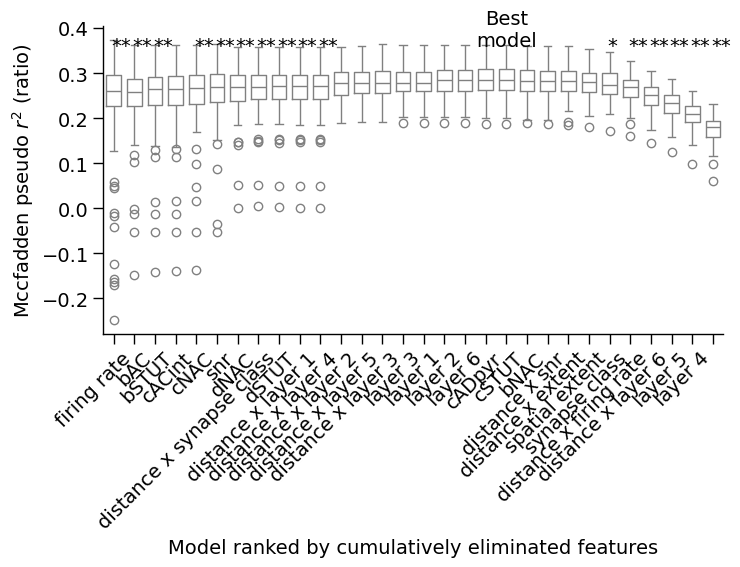

In [49]:
# takes 1 secs

from scipy.stats import ttest_ind

# PLOT MODELS R2

# create dataset of r2 to plot
plot_data = pd.DataFrame()
for ix in range(len(best_r2s)):
    data = np.vstack(
        [best_r2s[ix].astype(float), np.array(len(best_r2s[ix]) * [f"model_{ix}"])]
    ).T
    plot_data = pd.concat([plot_data, pd.DataFrame(data=data, columns=["r2", "model"])])

# cast r2s as floats
plot_data["r2"] = plot_data["r2"].astype(float)

# reset index
plot_data.reset_index(drop=True, inplace=True)

# plot boxplots
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax = sns.boxplot(
    ax=ax,
    data=plot_data,
    x="model",
    y="r2",
    fill=False,
    gap=0.1,
    color=(0.5, 0.5, 0.5),
    flierprops={"marker": "o"},
)
ax.set_xticks(np.arange(0, len(best_r2s), 1))
# ax.set_xticklabels(np.arange(0, len(best_r2s), 1))
ax.set_xticklabels(dropped_feats, rotation=45, ha="right")
ax.spines[["top", "right"]].set_visible(False)
ax.legend(frameon=False)
ax.set_ylabel("Mccfadden pseudo $r^2$ (ratio)")
ax.set_xlabel("Model ranked by cumulatively eliminated features")

# MARK THE BEST MODEL, MODELS NOT SIGNIFICANTLY BETTER AND OTHERS

# run t-test between the model with the highest r2 and the other models
# it is a one-sided test (tests whether best model has greater r2 than the others)

stats = []
mean_r2s = []
for ix in range(0, len(best_r2s)):
    mean_r2s.append(np.nanmean(best_r2s[ix]))

# identify best model
best_model_loc = np.array(mean_r2s).argmax()

# statistically compare best model with other models
for ix in range(0, len(best_r2s)):
    stats.append(
        ttest_ind(
            best_r2s[best_model_loc],
            best_r2s[ix],
            axis=0,
            equal_var=False,
            alternative="greater",
        )
    )

# flag best model
ax.annotate("Best\nmodel", (best_model_loc, 0.36), ha="center")

# flag models with significant p-values
# with best model
signifs = []
for ix in range(len(stats)):
    if stats[ix].pvalue < 0.01:
        signifs.append("**")
    elif stats[ix].pvalue < 0.05:
        signifs.append("*")
    else:
        signifs.append("")
for ix in range(len(stats)):
    ax.annotate(signifs[ix], (ix - 0.1, 0.35))

### Feature weights and R2

In [50]:
# takes 0.1 secs

# calculate feature weights on entire dataset
best_model_features = list(best_features[best_model_loc])

# create model formula
model_formula = "sorting_accuracy ~ 1 + " + " + ".join(map(str, best_model_features))

# train model
best_model_on_full_dataset = sm.GLM.from_formula(
    model_formula,
    family=sm.families.Binomial(),
    data=inter_dataset,
)
best_model_on_full_dataset = best_model_on_full_dataset.fit()
best_model_weights = best_model_on_full_dataset.params

### Plot prediction vs accuracy

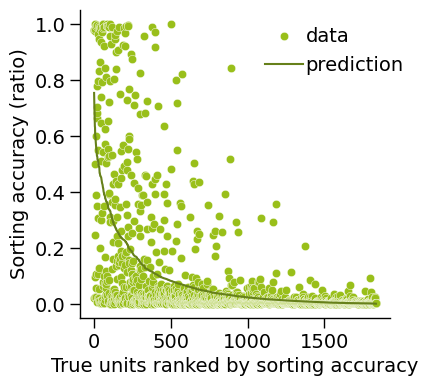

In [96]:
# FIGURE SETTINGS
MARKEREDGEWIDTH = 0.3

# compute predictions
prediction = best_model_on_full_dataset.model.predict(best_model_on_full_dataset.params)

# create plot dataset
fig, axis = plt.subplots(1, 1, figsize=FIG_SIZE)

# add prediction to dataset
inter_dataset["prediction"] = prediction

# sort
df_sorted = inter_dataset.sort_values(by="prediction", ascending=False)

# plot
axis.plot(
    df_sorted["sorting_accuracy"].values,
    "o",
    color=COLOR_STIM,
    markeredgecolor="w",
    markeredgewidth=MARKEREDGEWIDTH,
    label="data",
)
axis.plot(
    df_sorted["prediction"].values,
    "-",
    color=(0.4, 0.5, 0.1),
    linewidth=1.5,
    label="prediction",
)
axis.set_xlabel("True units ranked by sorting accuracy")
axis.set_ylabel("Sorting accuracy (ratio)")
axis.legend(**legend_cfg, bbox_to_anchor=(1.1, 1), loc="upper right")

# save figures
plt.savefig(
    "figures/3_sorting_biases/pdf/accuracy_prediction_evoked.pdf",
    bbox_inches="tight",
)
plt.savefig(
    "figures/3_sorting_biases/svg/accuracy_prediction_evoked.svg",
    bbox_inches="tight",
)

In [51]:
# takes 0.1 secs
best_model_r2 = mean_r2s[best_model_loc]

print("The most predictive features are:", best_model_features)
print("Best cross-validated r-squared:", best_model_r2)
print("The features weights are:\n", best_model_weights)
print("\np-values:", best_model_on_full_dataset.pvalues)

The most predictive features are: ['layer_4', 'layer_5', 'bNAC', 'cSTUT', 'distance', 'synapse_class', 'spatial_extent', 'distance_x_snr', 'distance_x_firing_rate', 'distance_x_extent', 'distance_x_layer_6']
Best cross-validated r-squared: 0.282421508415009
The features weights are:
 Intercept                -1.040568
layer_4                  -2.802760
layer_5                  -1.848423
bNAC                     -1.725276
cSTUT                     1.567985
distance                 -0.089167
synapse_class             1.253086
spatial_extent            0.001039
distance_x_snr            0.000918
distance_x_firing_rate    0.020853
distance_x_extent        -0.000027
distance_x_layer_6       -0.043418
dtype: float64

p-values: Intercept                 7.971235e-02
layer_4                   5.742403e-10
layer_5                   1.294616e-10
bNAC                      6.045117e-01
cSTUT                     1.446012e-01
distance                  2.804390e-07
synapse_class             4.614902e

* We Lose 9% of sorting accuracy every 1 um distance from an electrode
* We gain 1.267142 ... think about this later

In [65]:
# takes 1 min

# calculate the cross-validate adjusted pseudo r-squared of each feature
# of the best model. It the drop in r2 resulting from removing that feature
# from the model.

# make combinations without each feature
n_1_features = list(combinations(best_model_features, len(best_model_features) - 1))
test_feats = []
r2s = []

for ix in range(len(n_1_features)):
    # create model formula
    formula = "sorting_accuracy ~ 1 + " + " + ".join(map(str, n_1_features[ix]))

    # calculate their r2 (TODO: parallelize)
    r2s.append(
        get_crossval_mcf_r2(inter_dataset, formula, split_ratio=0.75, seeds=SEEDS)
    )

    # record tested feature (dropped one)
    test_feats.append(set(best_model_features) - set(n_1_features[ix]))

# cast as list of strings and clear feature names
test_feats_clean = [list(feat)[0] for feat in test_feats if not len(feat) == 0]


# correct -inf r-squared entries (set them to nan)
# when r-squared formula divide by 0 (loglike_null=0)
r2s_array = np.array(r2s)
r2s_array[r2s_array == -np.inf] = np.nan

# calculate each feature r-squared
r2 = np.nanmean(r2s_array, axis=1)
test_feat_r2 = best_model_r2 - r2

# adjust r2 so they sum to the best model's r2
adjust_scalar = best_model_r2 / sum(test_feat_r2)
test_feat_adjust_r2 = test_feat_r2 * adjust_scalar

# report in dataframe
test_features_r2_data = pd.DataFrame(
    data=test_feat_adjust_r2, columns=["r^2"], index=test_feats_clean
)

# add features r-squared
test_features_r2_data["r^2"] = test_features_r2_data["r2"].astype(float)

# add feature weights
weights_for_df = best_model_weights.drop(index="Intercept")
weights_df = weights_for_df.to_frame()
weights_df.columns = ["weights"]
data_df_0 = pd.merge(
    weights_df,
    test_features_r2_data,
    left_index=True,
    right_index=True,
)

# add p-values (fit to entire dataset)
pvalues_df = best_model_on_full_dataset.pvalues.drop(index="Intercept")
pvalues_df = pvalues_df.to_frame()
pvalues_df.columns = ["weight p-value"]
data_df = pd.merge(
    data_df_0,
    pvalues_df,
    left_index=True,
    right_index=True,
)

### Interpret feature weights

* The coefficients in a binomial glm represent log odds. 
* At x = 0, the log odds of a positive outcome is -0.3064. 
* This means the odds of a positive outcome is exp(-0.3064) or 0.736. As a probability, this is 0.736 / (1 + 0.736), or about 0.42. This is very close to the probability you specified of 0.4 at x = 0.

In [92]:
# pd.set_option("display.float_format", lambda x: "%.3f" % x if x > 0.0001 else x)

# interpret intercept
print("Intercept:")
print("- logodds of detected spike:", best_model_weights["Intercept"])
odds = np.exp(best_model_weights["Intercept"])
print("- odds of detected spike:", odds)
print(
    "- Probability of a detected spike when all features are null:", odds / (1 + odds)
)

# interpret features
odds = np.exp(best_model_weights["Intercept"] + data_df["weights"])
data_df[r"\Delta accuracy"] = np.sign(data_df["weights"]) * odds / (1 + odds)

# display
data_df = data_df.sort_values(by=["r^2"], ascending=False)
data_df

Intercept:
- logodds of detected spike: -1.040568160088077
- odds of detected spike: 0.3532539201533703
- Probability of a detected spike when all features are null: 0.26104038192132817


,weights,adjusted r2,p-value,\Delta accuracy
layer_4,-2.802760,0.093675,5.742403e-10,-0.020973
layer_5,-1.848423,0.069431,1.294616e-10,-0.052700
distance,-0.089167,0.036067,2.804390e-07,-0.244210
distance_x_layer_6,-0.043418,0.029977,8.001801e-06,-0.252752
distance_x_firing_rate,0.020853,0.027704,7.907228e-07,0.265083
synapse_class,1.253086,0.012588,4.614902e-03,0.552930
spatial_extent,0.001039,0.007178,1.133518e-02,0.261241
distance_x_extent,-0.000027,0.003305,8.378772e-02,-0.261035
distance_x_snr,0.000918,0.001251,1.157757e-01,0.261218
bNAC,-1.725276,0.000645,6.045117e-01,-0.059198


In [94]:
# copy paste to latex preprint
print(data_df.to_latex(index=True, formatters={"name": str.upper}, caption="Table 1."))

\begin{table}
\centering
\caption{Table 1.}
\begin{tabular}{lrrrr}
\toprule
{} &   weights &  adjusted r2 &       p-value &  \textbackslash Delta accuracy \\
\midrule
layer\_4                & -2.802760 &     0.093675 &  5.742403e-10 &        -0.020973 \\
layer\_5                & -1.848423 &     0.069431 &  1.294616e-10 &        -0.052700 \\
distance               & -0.089167 &     0.036067 &  2.804390e-07 &        -0.244210 \\
distance\_x\_layer\_6     & -0.043418 &     0.029977 &  8.001801e-06 &        -0.252752 \\
distance\_x\_firing\_rate &  0.020853 &     0.027704 &  7.907228e-07 &         0.265083 \\
synapse\_class          &  1.253086 &     0.012588 &  4.614902e-03 &         0.552930 \\
spatial\_extent         &  0.001039 &     0.007178 &  1.133518e-02 &         0.261241 \\
distance\_x\_extent      & -0.000027 &     0.003305 &  8.378772e-02 &        -0.261035 \\
distance\_x\_snr         &  0.000918 &     0.001251 &  1.157757e-01 &         0.261218 \\
bNAC                   & -1

### Plot relationship with features

- Hypotheses:
    - sorting accuracy increases (lots of samples) then decreases with firing rate (spike collision).

Text(0.5, 0, 'Distance ($\\mu$m)')

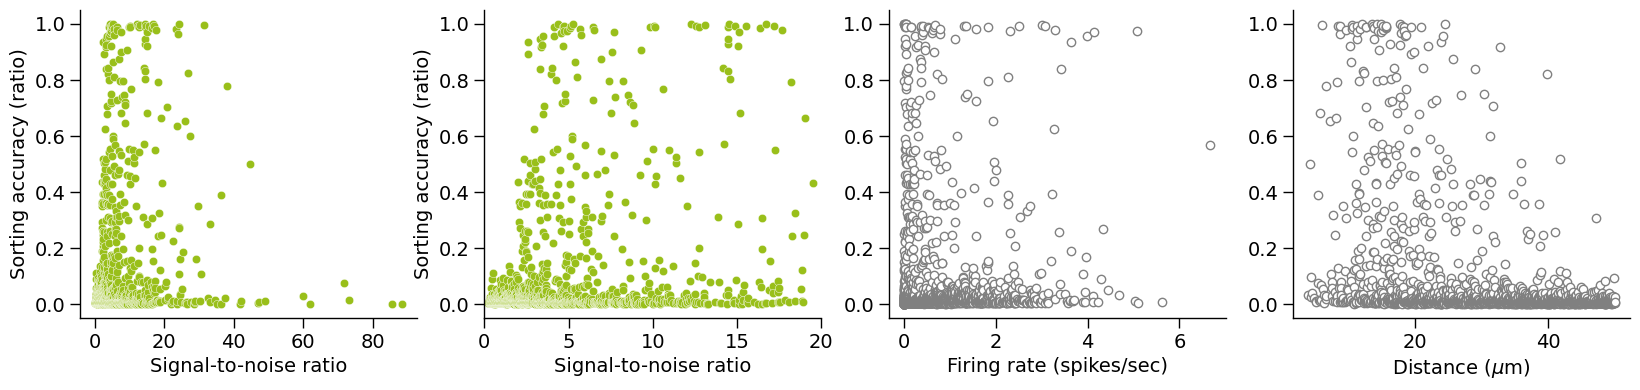

In [ ]:
FIG_SIZE = (20, 4)
fig, axes = plt.subplots(1, 4, figsize=FIG_SIZE)
axes[0].plot(
    inter_dataset.sort_values(by="snr")["snr"],
    inter_dataset.sort_values(by="snr")["sorting_accuracy"],
    linestyle="none",
    marker="o",
    markerfacecolor=COLOR_STIM,
    markeredgecolor="w",
    markeredgewidth=MARKEREDGEWIDTH,
)
axes[0].set_xlabel("Signal-to-noise ratio")
axes[0].set_ylabel("Sorting accuracy (ratio)")
# axes[0].set_xlim([0, 10])

axes[1].plot(
    inter_dataset.sort_values(by="snr")["snr"],
    inter_dataset.sort_values(by="snr")["sorting_accuracy"],
    linestyle="none",
    marker="o",
    markerfacecolor=COLOR_STIM,
    markeredgecolor="w",
    markeredgewidth=MARKEREDGEWIDTH,
)
axes[1].set_xlabel("Signal-to-noise ratio")
axes[1].set_ylabel("Sorting accuracy (ratio)")
axes[1].set_xlim([0, 20])


# firing rate
axes[2].plot(
    inter_dataset.sort_values(by="firing_rate")["firing_rate"],
    inter_dataset.sort_values(by="firing_rate")["sorting_accuracy"],
    linestyle="none",
    marker="o",
    markerfacecolor="w",
    markeredgecolor=(0.5, 0.5, 0.5),
)
axes[2].set_xlabel("Firing rate (spikes/sec)")


# distance
axes[3].plot(
    inter_dataset.sort_values(by="distance")["distance"],
    inter_dataset.sort_values(by="distance")["sorting_accuracy"],
    linestyle="none",
    marker="o",
    markerfacecolor="w",
    markeredgecolor=(0.5, 0.5, 0.5),
)
axes[3].set_xlabel("Distance ($\mu$m)")

### Other features

Text(0, 0.5, 'Sorting accuracy (ratio)')

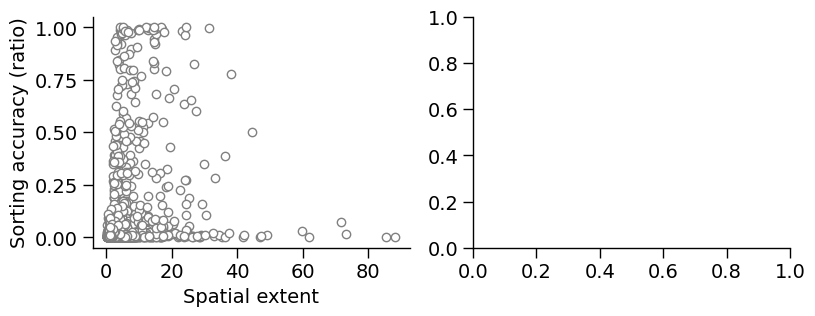

In [ ]:
FIG_SIZE = (3 * 3, 3)
fig, axes = plt.subplots(1, 2, figsize=FIG_SIZE)
axes[0].plot(
    inter_dataset.sort_values(by="spatial_extent")["snr"],
    inter_dataset.sort_values(by="spatial_extent")["sorting_accuracy"],
    linestyle="none",
    marker="o",
    markerfacecolor="w",
    markeredgecolor=(0.5, 0.5, 0.5),
)
axes[0].set_xlabel("Spatial extent")
axes[0].set_ylabel("Sorting accuracy (ratio)")

### Relationship between features

Text(0, 0.5, 'spatial_extent')

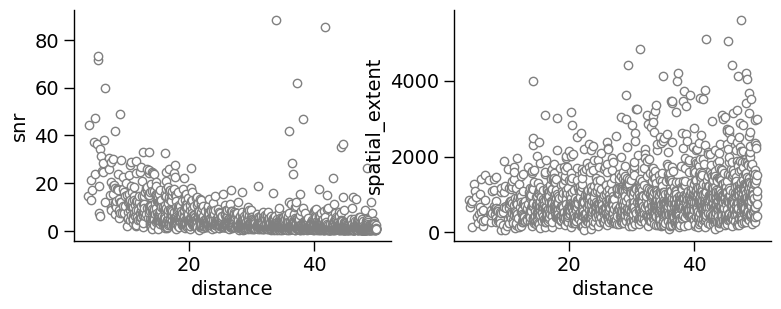

In [ ]:
FIG_SIZE = (3 * 3, 3)
fig, axes = plt.subplots(1, 2, figsize=FIG_SIZE)
axes[0].plot(
    inter_dataset.sort_values(by="distance")["distance"],
    inter_dataset.sort_values(by="distance")["snr"],
    linestyle="none",
    marker="o",
    markerfacecolor="w",
    markeredgecolor=(0.5, 0.5, 0.5),
)
axes[0].set_xlabel("distance")
axes[0].set_ylabel("snr")


axes[1].plot(
    inter_dataset.sort_values(by="distance")["distance"],
    inter_dataset.sort_values(by="distance")["spatial_extent"],
    linestyle="none",
    marker="o",
    markerfacecolor="w",
    markeredgecolor=(0.5, 0.5, 0.5),
)
axes[1].set_xlabel("distance")
axes[1].set_ylabel("spatial_extent")

### References

https://github.com/statsmodels/statsmodels/issues/9048
https://www.statsmodels.org/dev/examples/notebooks/generated/quasibinomial.html

https://www3.nd.edu/~rwilliam/stats3/L05.pdf

Mcfadden pseudo R2 equation:  
https://timeseriesreasoning.com/contents/r-squared-adjusted-r-squared-pseudo-r-squared/#:~:text=McFadden%27s%20Pseudo%2DR²%20is%20implemented,your%20fitted%20nonlinear%20regression%20model.

Mcfadden pseudo R2 interpretation (between 0.2 and 0.4 indicates excellent fit)  
https://stats.stackexchange.com/questions/82105/mcfaddens-pseudo-r2-interpretation

https://datascience.oneoffcoder.com/psuedo-r-squared-logistic-regression.html

https://stats.stackexchange.com/questions/386675/what-are-weights-in-a-binary-glm-and-how-to-calculate-them

https://stackoverflow.com/questions/72329673/binomial-glm-in-r-what-do-the-coefficients-talk-about
* **interpret weights**